In [76]:
import KID_model_functions as kids
import fitting_KID_model_functions as fitkids
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy import units as u, constants as c

In [116]:
save=True
plotlabel='taumax-bounded_no-nstar'
trans = 0.03

In [78]:
alpha = 0.73*u.dimensionless_unscaled
f = 331.6*u.MHz
Tstage = 0.215*u.K
Tc = 1.39*u.K
TBB_0 = 6.0*u.K
V = 38*1.5*0.8*np.power(u.micron,3) # volume w/20nm film is 38um3, multiply by 1.5 for ~30nm film, minus 20% for overetching trace width
eta_pb = 0.57
nu_opt = (350*u.micron).to(u.GHz,equivalencies=u.spectral())
N0=1.72e10*np.power(u.micron,-3)*np.power(u.eV,-1)

In [79]:
eta_opt = 0.8*u.dimensionless_unscaled
n_star = 1318*(np.power(u.micron,-3))
tau_max = 35*u.microsecond

In [80]:
TBBoptdata,f0optdata,xoptdata,sxxoptdata = np.loadtxt('optical_response_evap_devices/CD012_reduced_Res0.csv',delimiter=',',unpack=True)

In [81]:
Pincoptdata = kids.TBB_to_Pinc(TBBoptdata,trans=trans)

In [82]:
TBBoptpts = np.sort(list(set(TBBoptdata)))
Pincoptpts = kids.TBB_to_Pinc(TBBoptpts,trans=trans)

In [83]:
f0optpts = []
f0opterr = []
xoptpts = []
xopterr = []
sxxoptpts = []
sxxopterr = []


In [84]:
for temp in TBBoptpts:
    inds = np.where(TBBoptdata == temp)
    
    f0optpts.append(np.average(f0optdata[inds]))
    f0opterr.append(np.std(f0optdata[inds])/np.sqrt(len(inds)))
    
    xoptpts.append(np.average(xoptdata[inds]))
    xopterr.append(np.std(xoptdata[inds])/np.sqrt(len(inds)))
    
    sxxoptpts.append(np.average(sxxoptdata[inds]))
    sxxopterr.append(np.std(sxxoptdata[inds])/np.sqrt(len(inds)))
    

In [85]:
Tstagedarkdata,f0darkdata,xdarkdata,sxxdarkdata = np.loadtxt('optical_response_evap_devices/CD011_reduced_Res0.csv',delimiter=',',unpack=True)

In [86]:
Tstagedarkpts = np.sort(list(set(Tstagedarkdata)))
f0darkpts = []
f0darkerr = []
xdarkpts = []
xdarkerr = []
sxxdarkpts = []
sxxdarkerr = []

In [87]:
for temp in Tstagedarkpts:
    inds = np.where(Tstagedarkdata == temp)
    
    f0darkpts.append(np.average(f0darkdata[inds]))
    f0darkerr.append(np.std(f0darkdata[inds])/np.sqrt(len(inds)))
    
    xdarkpts.append(np.average(xdarkdata[inds]))
    xdarkerr.append(np.std(xdarkdata[inds])/np.sqrt(len(inds)))
    
    sxxdarkpts.append(np.average(sxxdarkdata[inds]))
    sxxdarkerr.append(np.std(sxxdarkdata[inds])/np.sqrt(len(inds)))
    

In [88]:
# triple simultaneous fit of x_opt,sxx_opt,sxx_dark for n_star,tau_max,eta_Opt, df,Sxx_0_Opt,S_xx_0_dark
# Independent variable
xdata = np.concatenate((TBBoptpts,TBBoptpts,Tstagedarkpts))
print(xdata)
len(xdata)
print(xdata[0:len(TBBoptpts)])
print(xdata[len(TBBoptpts):2*len(TBBoptpts)])
print(xdata[-len(Tstagedarkpts)::])

[5.61  5.75  5.95  6.65  7.1   7.45  7.8   5.61  5.75  5.95  6.65  7.1
 7.45  7.8   0.215 0.225 0.25  0.275 0.3   0.325]
[5.61 5.75 5.95 6.65 7.1  7.45 7.8 ]
[5.61 5.75 5.95 6.65 7.1  7.45 7.8 ]
[0.215 0.225 0.25  0.275 0.3   0.325]


In [89]:
# Parameters to hold constant in the fit
alpha = 0.73*u.dimensionless_unscaled
f = 331.6*u.MHz
Tstage = 0.215*u.K
Tc = 1.39*u.K
TBB_0 = 6.0*u.K
V = 38*1.5*0.8*np.power(u.micron,3) # volume w/20nm film is 38um3, multiply by 1.5 for ~30nm film, minus 20% for overetching trace width
eta_pb = 0.57
nu_opt = (350*u.micron).to(u.GHz,equivalencies=u.spectral())
N0=1.72e10*np.power(u.micron,-3)*np.power(u.eV,-1)

In [90]:
kids.nstar(tau_max,Tc)

<Quantity 4161.66121982 1 / micron3>

In [91]:
# function to fit x vs TBB
xoptfunc = lambda T_BBi,tau_maxp,eta_optp,dfp: kids.xMB(alpha,f,Tstage,Tc,T_BBi,V,kids.nstar(tau_max,Tc),tau_maxp,eta_pb,eta_optp,trans,N0)+(dfp*f.value)
# function to fit Sxx vs TBB
sxxoptfunc = lambda T_BBi,tau_maxp,eta_optp,Sxx0optp: kids.Sxx(alpha,f,Tstage,Tc,T_BBi,V,kids.nstar(tau_max,Tc),tau_maxp,eta_pb,nu_opt,eta_optp,trans,N0).value+Sxx0optp
# function to fit Sxx vs Tstage
sxxdarkfunc = lambda T_stagei,tau_maxp,Sxx0darkp: kids.Sxx(alpha,f,T_stagei,Tc,TBB_0,V,kids.nstar(tau_max,Tc),tau_maxp,eta_pb,nu_opt,eta_opt=0,trans=0,N0=N0).value+Sxx0darkp

combfunc = lambda datai,tau_maxp,eta_optp,dfp,Sxx0optp,Sxx0darkp: np.concatenate((xoptfunc(datai[0:len(TBBoptpts)],tau_maxp,eta_optp,dfp),sxxoptfunc(datai[len(TBBoptpts):2*len(TBBoptpts)],tau_maxp,eta_optp,Sxx0optp),sxxdarkfunc(datai[-len(Tstagedarkpts)::],tau_maxp,Sxx0darkp)))

In [92]:
ydata = np.concatenate((xoptpts,sxxoptpts,sxxdarkpts))
yerr = np.concatenate((xopterr,sxxopterr,sxxdarkerr))

# [tau_max,eta_opt,df,Sxx0opt,Sxx0dark]
p0 = [50,.8,1e-8,.5e-17,.5e-17]
bounds = ([40,0.1,-1,1e-19,1e-19],[60,1,1,np.min(sxxoptpts),np.min(sxxdarkpts)])
                       
comb_popt,comb_pcov = curve_fit(combfunc,xdata,ydata,p0=p0,sigma=yerr,bounds=bounds)
tau_max_fit,eta_opt_fit,df_fit,Sxx0opt_fit,Sxx0dark_fit = comb_popt
n_star_fit = kids.nstar(tau_max_fit,Tc)
print(comb_popt)
print(n_star_fit)

[4.00000000e+01 1.22192221e-01 3.55886790e-08 3.08967903e-18
 1.00000000e-19]
3641.4535673407963 1 / micron3


In [93]:
np.min(sxxoptpts)

2.058592847919844e-17

In [94]:
Tstagefit = np.linspace(Tstagedarkpts.min(),Tstagedarkpts.max(),num=50)
sxxdarkfit = sxxdarkfunc(Tstagefit,tau_max_fit,Sxx0dark_fit)

TBBfit = np.linspace(TBBoptpts.min(),TBBoptpts.max(),num=50)
xoptfit = xoptfunc(TBBfit,tau_max_fit,eta_opt_fit,df_fit)
sxxoptfit = sxxoptfunc(TBBfit,tau_max_fit,eta_opt_fit,Sxx0opt_fit)

SxxGphoton = kids.Sxx_G_photon(alpha,f,Tstage,Tc,TBBfit,V,n_star_fit,tau_max_fit,eta_pb,nu_opt,eta_opt_fit,trans,N0)
SxxRphoton = kids.Sxx_R_photon(alpha,f,Tstage,Tc,TBBfit,V,n_star_fit,tau_max_fit,eta_pb,nu_opt,eta_opt_fit,trans,N0)
SxxGRth = kids.Sxx_GR_th(alpha,f,Tstage,Tc,TBBfit,V,n_star_fit,tau_max_fit,eta_pb,nu_opt,eta_opt_fit,trans,N0)


In [95]:
cell_text = [['parameter','fit value','unit'],
             [r'$n^*$','{:.0f}'.format(n_star_fit.value),r'$\mu m^{-3}$'], 
             [r'$\tau_{max}$','{:.0f}'.format(tau_max_fit),r'$\mu$s'], 
             [r'$\eta_{opt}$','{:.0f}'.format(100*eta_opt_fit),'%'], 
             ['df','{:.1e}'.format(df_fit),r'MHz$^{-1}$'], 
             [r'$Sxx_{0,opt}$','{:.1e}'.format(Sxx0opt_fit),r'Hz$^{-1}$'], 
             [r'$Sxx_{0,dark}$','{:.1e}'.format(Sxx0dark_fit),r'Hz$^{-1}$']]


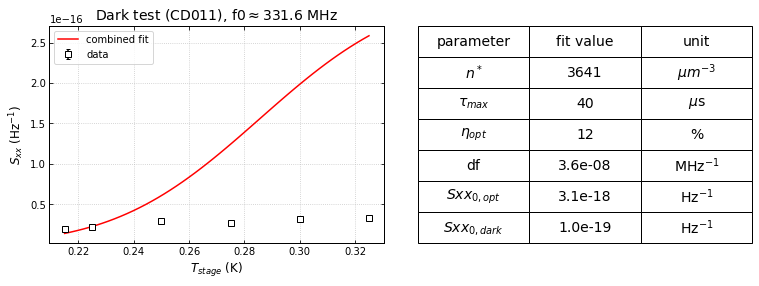

In [117]:
plt.errorbar(x=Tstagedarkpts,y=sxxdarkpts,yerr=sxxdarkerr,linestyle=None,fmt='s',markerfacecolor='w',markeredgecolor='k',ecolor='k',label='data')
plt.plot(Tstagefit,sxxdarkfit,'r-',label='combined fit')
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.xlabel(r'$T_{stage}$ (K)')
plt.ylabel(r'$S_{xx}$ (Hz$^{-1}$)')
plt.title(r'Dark test (CD011), f0$\approx$331.6 MHz')
plt.legend(loc='upper left')

the_table = plt.table(cellText=cell_text, loc='right',cellLoc='center',bbox=[1.1, 0, 1, 1])
the_table.auto_set_font_size(False)
the_table.set_fontsize(14)    

if save==True: plt.savefig('C:\\Users\\Alyssa\\Penn Google Drive\\Penn & NSTRF\\Caltech Devices\\Evap_Devices_Analysis\\evap_devices\\trifitplots\\CD011_res0_Sxx_vs_Tstage_'+plotlabel+'.png')

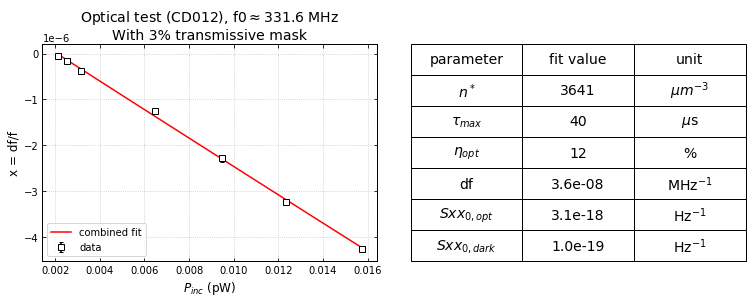

In [118]:
plt.errorbar(x=Pincoptpts.value,y=xoptpts,yerr=xopterr,linestyle=None,fmt='s',markerfacecolor='w',markeredgecolor='k',ecolor='k',label='data')
plt.plot(kids.TBB_to_Pinc(TBBfit,trans),xoptfit,'r-',label='combined fit')
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.xlabel(r'$P_{inc}$ (pW)')
plt.ylabel('x = df/f')
plt.title(r'Optical test (CD012), f0$\approx$331.6 MHz' + '\n' + 'With 3% transmissive mask')
plt.legend(loc='lower left')

the_table = plt.table(cellText=cell_text, loc='right',cellLoc='center',bbox=[1.1, 0, 1, 1])
the_table.auto_set_font_size(False)
the_table.set_fontsize(14)    

if save==True: plt.savefig('C:\\Users\\Alyssa\\Penn Google Drive\\Penn & NSTRF\\Caltech Devices\\Evap_Devices_Analysis\\evap_devices\\trifitplots\\CD012_res0_x_vs_Pinc_'+plotlabel+'.png')

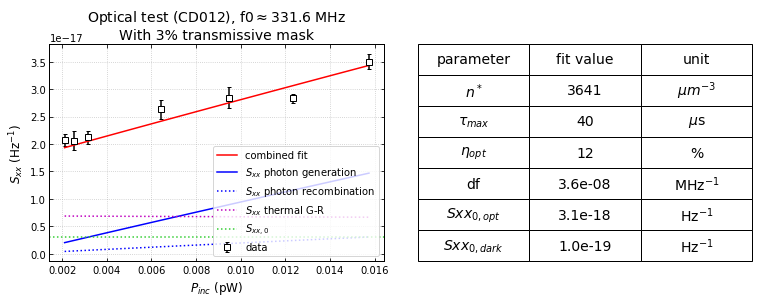

In [119]:
plt.errorbar(x=Pincoptpts.value,y=sxxoptpts,yerr=sxxopterr,linestyle=None,fmt='s',markerfacecolor='w',markeredgecolor='k',ecolor='k',label='data')
plt.plot(kids.TBB_to_Pinc(TBBfit,trans),sxxoptfit,'r-',label='combined fit')
plt.plot(kids.TBB_to_Pinc(TBBfit,trans),SxxGphoton,linestyle='-',color='b',label=r'$S_{xx}$ photon generation')
plt.plot(kids.TBB_to_Pinc(TBBfit,trans),SxxRphoton,linestyle=':',color='b',label=r'$S_{xx}$ photon recombination')
plt.plot(kids.TBB_to_Pinc(TBBfit,trans),SxxGRth,linestyle=':',color='m',label=r'$S_{xx}$ thermal G-R')
plt.axhline(y=Sxx0opt_fit,linestyle=':',color='limegreen',label=r'$S_{xx,0}$')
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

plt.xlabel(r'$P_{inc}$ (pW)')
plt.ylabel(r'$S_{xx}$ (Hz$^{-1}$)')
plt.title(r'Optical test (CD012), f0$\approx$331.6 MHz' + '\n' + 'With 3% transmissive mask')
plt.legend(loc='lower right')

the_table = plt.table(cellText=cell_text, loc='right',cellLoc='center',bbox=[1.1, 0, 1, 1])
the_table.auto_set_font_size(False)
the_table.set_fontsize(14)    

if save==True: plt.savefig('C:\\Users\\Alyssa\\Penn Google Drive\\Penn & NSTRF\\Caltech Devices\\Evap_Devices_Analysis\\evap_devices\\trifitplots\\CD012_res0_sxx_vs_Pinc_'+plotlabel+'.png')

In [99]:
tau_max_fit*=u.microsecond

In [100]:
n_star_fit

<Quantity 3641.45356734 1 / micron3>

In [101]:
tau_max_fit

<Quantity 40. us>

In [102]:
Tc 

<Quantity 1.39 K>

In [103]:
R1 = np.power(n_star_fit*tau_max_fit,-1)

In [104]:
R1

<Quantity 6.8653903e-06 micron3 / us>

In [105]:
tau_0 = 438e-9*u.second

In [106]:
R2 = (np.power(2*kids.delta0(Tc),2)/(2*N0*tau_0*np.power(c.k_B*Tc,3))).to(R1.unit)

In [107]:
R2

<Quantity 6.8653903e-06 micron3 / us>

In [108]:
R1/R2

<Quantity 1.>

In [109]:
1./(R2*tau_max_fit)

<Quantity 3641.45356734 1 / micron3>

In [110]:
# what do good detectors look like???
alpha = 0.73*u.dimensionless_unscaled
f = 331.6*u.MHz
Tstage = 0.215*u.K
Tc = 1.1*u.K
TBB_0 = 6.0*u.K
V = 38*1.5*0.8*np.power(u.micron,3) # volume w/20nm film is 38um3, multiply by 1.5 for ~30nm film, minus 20% for overetching trace width
eta_pb = 0.57
nu_opt = (350*u.micron).to(u.GHz,equivalencies=u.spectral())
N0=1.72e10*np.power(u.micron,-3)*np.power(u.eV,-1)

tau_max = 60*u.microsecond
eta_opt = 0.6
n_star = 100*np.power(u.micron,-3)#1./(R2*tau_max_fit)

TBB = TBBfit
trans = 0.03

In [111]:
Sxx_m1 = kids.Sxx(alpha,f,Tstage,Tc,TBB,V,n_star,tau_max,eta_pb,nu_opt,eta_opt,trans,N0)

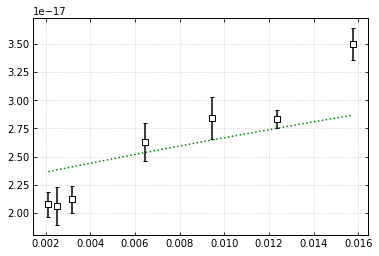

In [112]:
plt.errorbar(x=kids.TBB_to_Pinc(TBBoptpts,trans).value,y=sxxoptpts,yerr=sxxopterr,linestyle=None,fmt='s',markerfacecolor='w',markeredgecolor='k',ecolor='k',label='data')
plt.plot(kids.TBB_to_Pinc(TBB,trans),Sxx_m1,'g:')

In [113]:
TBBoptpts

array([5.61, 5.75, 5.95, 6.65, 7.1 , 7.45, 7.8 ])

In [114]:
pwd

'C:\\Users\\Alyssa\\STARsoft\\Python'